In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import fmin
from scipy.integrate import odeint
from tqdm import tqdm

plt.style.use('bmh')
warnings.filterwarnings('ignore')


In [2]:

class ModeleGluIns3():
    '''
    Modèle Insuline / Glucose à 2 compartiments avec
    évolution de la vitesse d'absorption au cours du temps.

    Paramètres:
    ----------
    - t : liste, vecteur temps
    - y0 : tuple, conditions initiales
    - param : DataFrame de la forme {'paramètre': (valeur, bool), ...}
        pour chacun des paramètres du modèle. True pour optimiser le
        paramètre, False pour garder sa valeur initiale.
        - a : pondération glycolyse hépatique
        - b : dégradation de G
        - c : dégradation de I
        - d : coef de G^2
        - gs : seuil de libération de la glycolyse hépatique
        - k : coef de vitesse d'absorption du glucose par l'instestin
        - U0 : vitesse d'absorption du glucose par l'instestin initiale

    Méthodes:
    --------
    - fit : pour faire fiter le modèle à des données expérimentales.
    - simulation : pour simuler le modèle à partir de paramètres connus.
    - get_param : pour obtenir les paramètres du modèle
    '''

    def __init__(self, t, y0, param):
        self.t_ = t
        self.y0_ = y0
        self.param_ = param.copy()
        self.update_param()

    def update_param(self):
        self.a_ = self.param_['a'][0]
        self.b_ = self.param_['b'][0]
        self.c_ = self.param_['c'][0]
        self.d_ = self.param_['d'][0]
        self.gs_ = self.param_['gs'][0]
        self.k_ = self.param_['k'][0]
        self.U0_ = self.param_['U0'][0]

    def get_param(self):
        return [self.a_, self.b_, self.c_, self.d_, self.gs_, self.k_, self.U0_]

    def model(self, y, t, a, b, c, d, gs, k, U0):
        #-- Initialisation
        G, I, Gi = y
        #-- Diminution exponentielle de la vitesse
        U = U0 * np.exp(-k*t)
        #-- ODEs
        dGdt = a*max(0, gs-G) + U*Gi - b*I*G 
        dIdt = d*G**2 - c*I 
        dGidt = - U*Gi
        return [dGdt, dIdt, dGidt]

    def simulation(self):
        return odeint(self.model, self.y0_, self.t_, args=(self.a_, self.b_, self.c_, self.d_, self.gs_, self.k_, self.U0_ ))

    def sse(self, param):
        #-- Paramètres à optimiser
        *p, = param
        #-- Assignation des paramètres à optimiser ou non
        i = 0
        if self.param_['a'][1] == True:
            a = p[i]
            i += 1
        else:
            a = self.a_
        if self.param_['b'][1] == True:
            b = p[i]
            i += 1
        else:
            b = self.b_
        if self.param_['c'][1] == True:
            c = p[i]
            i += 1
        else:
            c = self.c_
        if self.param_['d'][1] == True:
            d = p[i]
            i += 1
        else:
            d = self.d_
        if self.param_['gs'][1] == True:
            gs = p[i]
            i += 1
        else:
            gs = self.gs_
        if self.param_['k'][1] == True:
            k = p[i]
            i += 1
        else:
            k = self.k_
        if self.param_['U0'][1] == True:
            U0 = p[i]
            i += 1
        else:
            U0 = self.U0_
        #-- ODE
        y = odeint(func=self.model, y0=self.y0_, t=self.data[:, 0], args=(a, b, c, d, gs, k, U0, ))
        #-- Calcul du SSE avec pénalités
        penalties = (a<0)*1e8 + (b<0)*1e8 + (c<0)*1e8 + (d<0)*1e8 + (gs<0)*1e8 + (k<0)*1e8 + (U0<0)*1e8 + (gs>300)*1e8 + (gs<50)*1e8
        if self.data_multiple == False:
            return np.sum(((self.data_fit - y[:, 0])/self.sd)**2) + penalties
        elif self.data_multiple == True:
            sse = 0
            for i in range(0, 10):
                sse += np.sum(((self.data_fit[i] - y[:, 0])/self.sd)**2)
            return sse

    def fit(self, data, data_fit, sd=1, data_multiple=False):
        self.data_fit = data_fit 
        self.data = data 
        self.sd = sd # écart type de data_fit
        self.data_multiple = data_multiple
        #-- Ajoute dans la liste param les paramètres que l'on souhaite optimiser
        param_a_opti = []
        for i in range(0, len(self.param_.loc[0, :])):
            if self.param_.iloc[1, i] == True:
                param_a_opti.append(self.param_.iloc[0, i])
            else :
                pass
        #-- minimisation et récupération des paramètres optimisés
        self.param_opti = fmin(self.sse, param_a_opti, maxiter=3000, disp=False)
        #-- mise à jour des paramètres
        j = 0
        for i in range(0, len(self.param_.loc[0, :])):
            if self.param_.iloc[1, i] == True:
                self.param_.iloc[0, i] = self.param_opti[j]
                j += 1
            else :
                pass
        self.update_param()
        return self.simulation()


# Modèle avancé

In [3]:
#-- Importation des données expérimentales
data = np.loadtxt('C:/Users/thide/OneDrive/master/M1/MU4BI030_Physiologie_des_Systèmes/Projet/data/full_ogtt.txt')

#-- Temps
t = np.linspace(data[:, 0][0], data[:, 0][-1] + 50, 2000)
t2 = np.linspace(0, 200, 2000)

#-- Conditions initiales
y0 = (data[:, -1][0], 20, 4500)

#-- paramètres initiaux   
param = pd.DataFrame.from_dict({
    'a': (0.06, False), # fixe
    'b': (1.76e-03, True),
    'c': (3e-02, False), # fixe
    'd': (5e-05, False), # fixe
    'gs': (150, True),
    'k': (1.8e-02, False), # fixe
    'U0': (0.005, True),
})


OSError: C:/Users/thide/OneDrive/master/M1/MU4BI030_Physiologie_des_Systèmes/Projet/data/full_ogtt.txt not found.

### Figure 1 - modèle général

In [ ]:
#-- calcul de l'écart-type
yerr = []
for ligne in data:
    yerr.append(np.std(ligne[1:-1]))

Fit sur une courbe

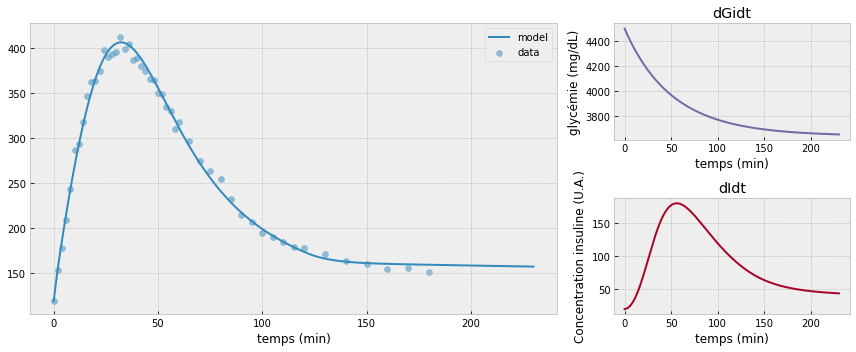

[0.06, 0.00016649392533999008, 0.03, 5e-05, 172.16686459989984, 0.018, 0.003795829327410448]


In [ ]:
#-- simulation
model1 = ModeleGluIns3(t, y0, param)
y = model1.fit(data, data[:, -1], sd=yerr)

#-- création figure
plt.figure(figsize=(12, 5))
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 2))

#-- tracé des courbes
ax1.plot(t, y[:, 0], label='model')
ax1.scatter(data[:, 0], data[:, -1], alpha=0.5, label='data')
ax2.plot(t, y[:, 2], c='C2')
ax3.plot(t, y[:, 1], c='C1')

#-- légendes
ax1.set_xlabel('temps (min)')
ax1.legend()
ax2.set_xlabel('temps (min)')
ax2.set_ylabel('glycémie (mg/dL)')
ax2.set_title('dGidt')
ax3.set_xlabel('temps (min)')
ax3.set_ylabel("Concentration insuline (U.A.)")
ax3.set_title('dIdt')

#-- affichage
plt.tight_layout()
plt.show()

#-- affichage des paramètre
print(model1.get_param())

In [ ]:
print([y[:,2][0]-y[:,2][-1]])

[843.3194173999705]


Fit sur toutes les données en même temps

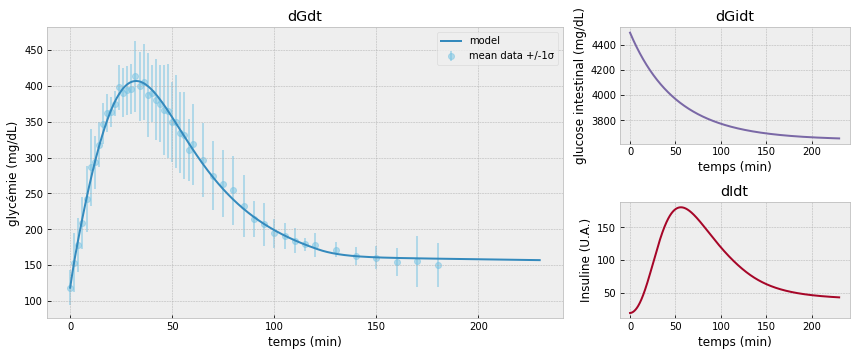

[0.06, 0.0001664941783634518, 0.03, 5e-05, 172.16856145583324, 0.018, 0.0037956911849137344]


In [ ]:
#-- simulation
model2 = ModeleGluIns3(t, y0, param)
all_data = [data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5], data[:, 6], data[:, 7], data[:, 8], data[:, 9], data[:, 10]]
y2 = model2.fit(data, all_data, sd=yerr, data_multiple=True)

#-- création figure
plt.figure(figsize=(12, 5))
ax1 = plt.subplot2grid((2, 3), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((2, 3), (0, 2))
ax3 = plt.subplot2grid((2, 3), (1, 2))

#-- tracé des courbes
ax1.plot(t, y2[:, 0], label='model', zorder=2)
ax1.errorbar(data[:, 0], data[:, -1], yerr, fmt='o', alpha=0.5, lw=2, label='mean data +/-1σ', c='#75C3E4', zorder=1)
#ax1.fill_between(data[:, 0], data[:, -1]+yerr, data[:, -1]-yerr, alpha=0.2, zorder=0, label='data +/-1σ')
ax2.plot(t, y2[:, 2], c='C2')
ax3.plot(t, y2[:, 1],  c='C1', label='Insuline model')

#-- légendes
ax1.set_xlabel('temps (min)')
ax1.set_ylabel('glycémie (mg/dL)')
ax1.set_title('dGdt')
ax1.legend()
ax2.set_xlabel('temps (min)')
ax2.set_ylabel('glucose intestinal (mg/dL)')
ax2.set_title('dGidt')
ax3.set_xlabel('temps (min)')
ax3.set_ylabel("Insuline (U.A.)")
ax3.set_title('dIdt')

#-- affichage
plt.tight_layout()
plt.show()

#-- affichage des paramètre
print(model2.get_param())

In [ ]:
print([y2[:,2][0]-y2[:,2][-1]])

[843.291800640357]


In [ ]:
param = pd.DataFrame.from_dict({
    'a': (model2.get_param()[0], False),
    'b': (model2.get_param()[1], True),
    'c': (model2.get_param()[2], False),
    'd': (model2.get_param()[3], False),
    'gs': (model2.get_param()[4], True),
    'k': (model2.get_param()[5], False),
    'U0': (model2.get_param()[6], True),
})

### Figure 2 - modèle pour chaque souris

100%|██████████| 10/10 [00:03<00:00,  2.60it/s]


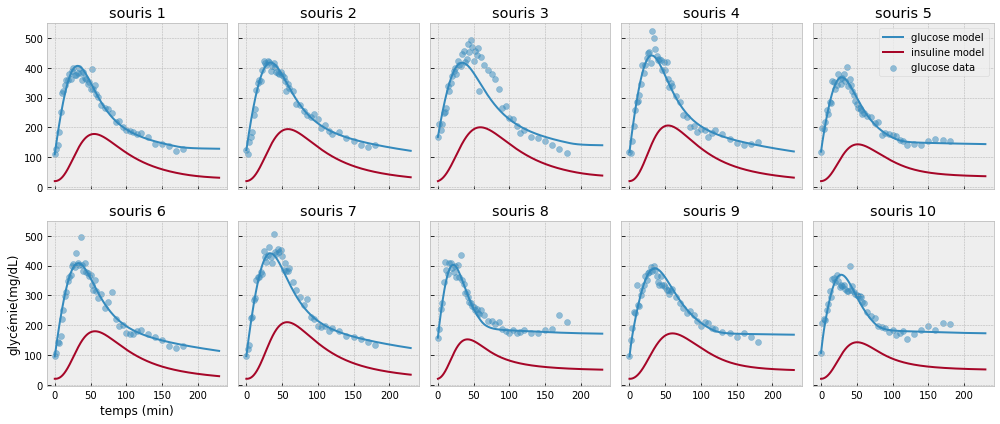

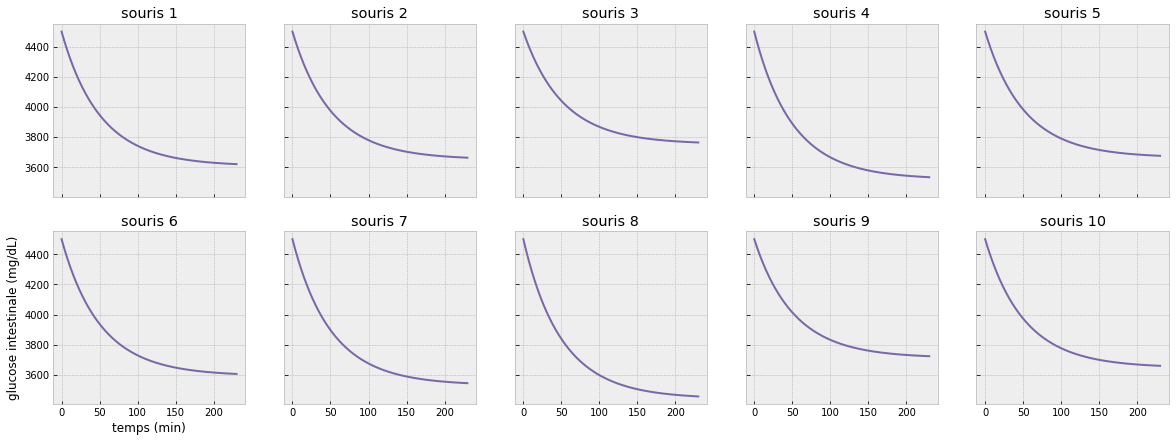

In [ ]:
#-- création figure
fig1, axs1 = plt.subplots(2, 5, figsize=(14, 6), sharey=True, sharex=True)
fig2, axs2 = plt.subplots(2, 5, figsize=(20, 7), sharey=True, sharex=True)

#-- initialisation list et flag
j, w = 0, 0
list_param_souris = []
valeur_gi_souris = []

for i in tqdm(range(1, 11)):
    #-- sélection subplot
    if i == 6:
        j, w = 1, 0
    #-- sélection souris
    souris = data[:, i]
    #-- simulation
    model = ModeleGluIns3(t, (souris[0], 20, 4500), param)
    y = model.fit(data, souris, sd=yerr)
    #-- ajout des paramètres à une liste
    list_param_souris.append(model.get_param())
    #-- ajout de la quantité de glucose absorbé à une liste
    valeur_gi_souris.append([y[:,2][0] - y[:,2][-1]])
    #-- figure 1
    axs1[j][w].plot(t, y[:, 0], label='glucose model')
    axs1[j][w].plot(t, y[:, 1], label='insuline model')
    axs1[j][w].scatter(data[:, 0], souris, alpha=0.5, label='glucose data')
    axs1[j][w].set_title(f'souris {i}')
    #-- figure 2 
    axs2[j][w].plot(t, y[:, 2], c='C2')
    axs2[j][w].set_title(f'souris {i}')
    w += 1
    
#-- légende
axs1[0][4].legend()
axs1[1][0].set_ylabel('glycémie(mg/dL)')
axs1[1][0].set_xlabel('temps (min)')
axs2[1][0].set_ylabel('glucose intestinale (mg/dL)')
axs2[1][0].set_xlabel('temps (min)')

#-- affichage
fig1.tight_layout()
plt.show()


In [ ]:
np.mean(valeur_gi_souris)

875.5677404363239

In [ ]:
np.std(valeur_gi_souris)

88.3294096399178

#### Exportation des paramètres

In [ ]:
#-- nom des colones et des index pour le dataframe
index = ['Souris 1', 'Souris 2', 'Souris 3', 'Souris 4', 'Souris 5', 'Souris 6', 'Souris 7', 'Souris 8', 'Souris 9', 'Souris 10']
columns = ['a', 'b', 'c', 'd', 'gs', 'k', 'U0']

#-- Création dataframe 
df_souris = pd.DataFrame(data=list_param_souris, index=index, columns=columns)

#-- afficahge 
print(df_souris)
print(df_souris.describe())

#-- exportation 
df_souris.describe().to_excel('param_modele_avance_souris.xlsx')

              a         b     c        d          gs      k        U0
Souris 1   0.06  0.000178  0.03  0.00005  136.311787  0.018  0.003979
Souris 2   0.06  0.000143  0.03  0.00005  108.234462  0.018  0.003764
Souris 3   0.06  0.000120  0.03  0.00005  147.526364  0.018  0.003266
Souris 4   0.06  0.000160  0.03  0.00005  107.545903  0.018  0.004422
Souris 5   0.06  0.000244  0.03  0.00005  161.369088  0.018  0.003702
Souris 6   0.06  0.000176  0.03  0.00005   80.808615  0.018  0.004054
Souris 7   0.06  0.000147  0.03  0.00005   85.869693  0.018  0.004368
Souris 8   0.06  0.000330  0.03  0.00005  213.869235  0.018  0.004828
Souris 9   0.06  0.000154  0.03  0.00005  185.220249  0.018  0.003466
Souris 10  0.06  0.000254  0.03  0.00005  206.013779  0.018  0.003783
                  a          b             c             d          gs  \
count  1.000000e+01  10.000000  1.000000e+01  1.000000e+01   10.000000   
mean   6.000000e-02   0.000191  3.000000e-02  5.000000e-05  143.276918   
std    1

# Modèle pathologique

In [ ]:
#-- Importation des données expérimentales
data_ko = np.loadtxt('C:/Users/thide/OneDrive/master/M1/MU4BI030_Physiologie_des_Systèmes/Projet/data/ko_corr.txt') # n=14
data_control = np.loadtxt('C:/Users/thide/OneDrive/master/M1/MU4BI030_Physiologie_des_Systèmes/Projet/data/control_corr.txt') # n=15


### Figure 3 - souris contrôle

In [ ]:
#-- calcul de l'écart-type
yerr_control = []
for ligne in data_control:
    yerr_control.append(np.std(ligne[1:-1]))

100%|██████████| 15/15 [00:06<00:00,  2.36it/s]


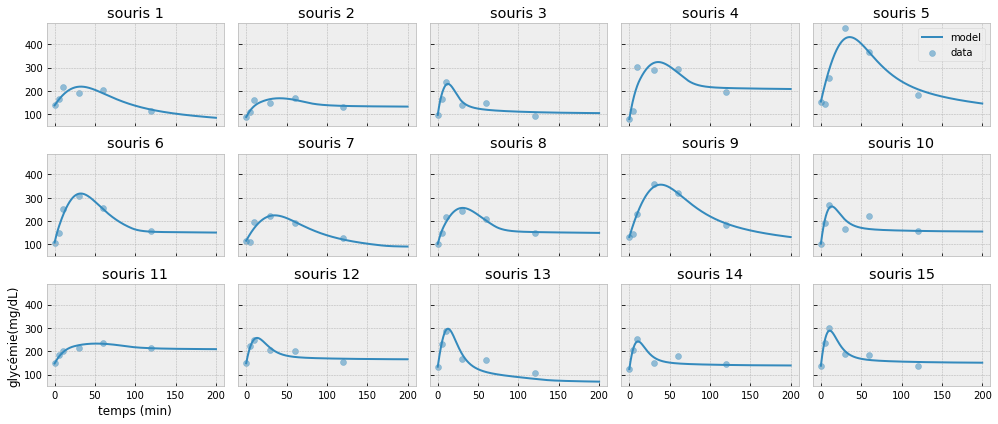

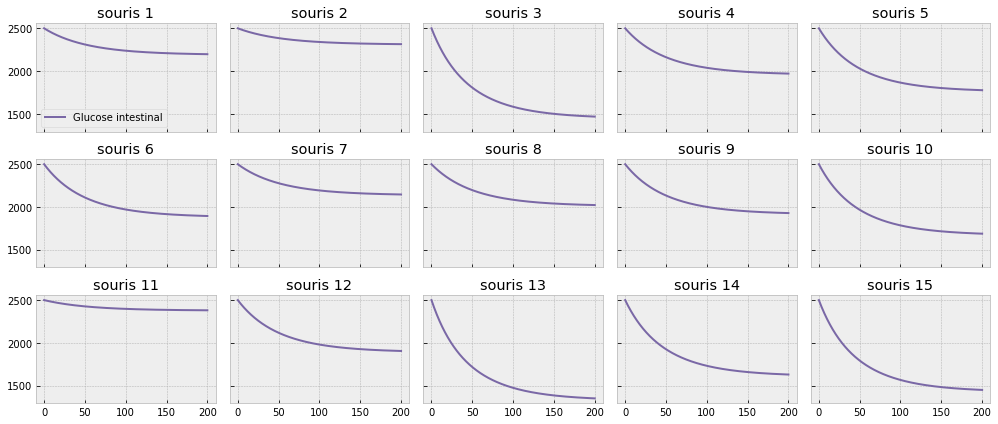

In [ ]:
#-- Création figure
fig1, axs1 = plt.subplots(3, 5, figsize=(14, 6), sharex=True, sharey=True)
fig2, axs2 = plt.subplots(3, 5, figsize=(14, 6), sharex=True, sharey=True)

#-- initialisation list et flag
j, w = 0, 0
list_param_souris_control = []
valeur_gi_souris_control = []

for i in tqdm(range(1, 16)):
    #-- sélection subplot
    if i == 6:
        j, w = 1, 0
    if i == 11:
        j, w = 2, 0
    #-- sélection souris
    souris_control = data_control[1:, i]
    #-- simulation
    model = ModeleGluIns3(t2, (souris_control[0], 20, 2500), param)
    y = model.fit(data_control[1:, :], souris_control)
    #-- ajout des paramètres à une liste
    list_param_souris_control.append(model.get_param())
    #-- ajout de la valeur de Gi dans une liste
    valeur_gi_souris_control.append([y[:,2][0] - y[:,2][-1]])
    #-- figure 1
    axs1[j][w].plot(t2, y[:, 0], label='model')
    axs1[j][w].scatter(data_control[1:, 0], souris_control, alpha=0.5, label='data')
    axs1[j][w].set_title(f'souris {i}')
    #-- figure 2
    axs2[j][w].plot(t2, y[:, 2], label='Glucose intestinal', c='C2')
    axs2[j][w].set_title(f'souris {i}')
    w += 1
    
#-- légende
axs1[0][4].legend()
axs1[2][0].set_ylabel('glycémie(mg/dL)')
axs1[2][0].set_xlabel('temps (min)')
axs2[0][0].legend()

#-- affichage
fig1.tight_layout()
fig2.tight_layout()
fig1.show()
fig2.show()

In [ ]:
#-- nom des colones et des index pour le dataframe
index_control = []
for i in range(1, 16):
    index_control.append(f'Souris {i}')
columns = ['a_ctrl', 'b_ctrl', 'c_ctrl', 'd_ctrl', 'gs_ctrl', 'k_ctrl', 'U0_ctrl']

#-- Création dataframe
df_souris_control = pd.DataFrame(data=list_param_souris_control, index=index_control, columns=columns)

#-- afficahge
print(df_souris_control)

#-- exportation
df_souris_control.to_excel('param_modele_avance_souris_control.xlsx')
df_souris_control.to_csv('param_modele_avance_souris_control.csv', header=True, index=True)

           a_ctrl    b_ctrl  c_ctrl   d_ctrl     gs_ctrl  k_ctrl   U0_ctrl
Souris 1     0.06  0.000295    0.03  0.00005   73.843101   0.018  0.002390
Souris 2     0.06  0.000282    0.03  0.00005  149.322659   0.018  0.001426
Souris 3     0.06  0.002268    0.03  0.00005  172.378060   0.018  0.009868
Souris 4     0.06  0.000172    0.03  0.00005  247.601290   0.018  0.004409
Souris 5     0.06  0.000104    0.03  0.00005   91.394902   0.018  0.006328
Souris 6     0.06  0.000235    0.03  0.00005  169.681814   0.018  0.005138
Souris 7     0.06  0.000305    0.03  0.00005   95.603757   0.018  0.002826
Souris 8     0.06  0.000344    0.03  0.00005  178.220592   0.018  0.003927
Souris 9     0.06  0.000126    0.03  0.00005  117.505677   0.018  0.004806
Souris 10    0.06  0.001424    0.03  0.00005  299.999989   0.018  0.007278
Souris 11    0.06  0.000053    0.03  0.00005  221.803323   0.018  0.000904
Souris 12    0.06  0.001080    0.03  0.00005  299.999907   0.018  0.005032
Souris 13    0.06  0.0014

### Figure 4 - souris ko

In [ ]:
#-- calcul de l'écart-type
yerr_ko = []
for ligne in data_ko:
    yerr_ko.append(np.std(ligne[1:-1]))

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


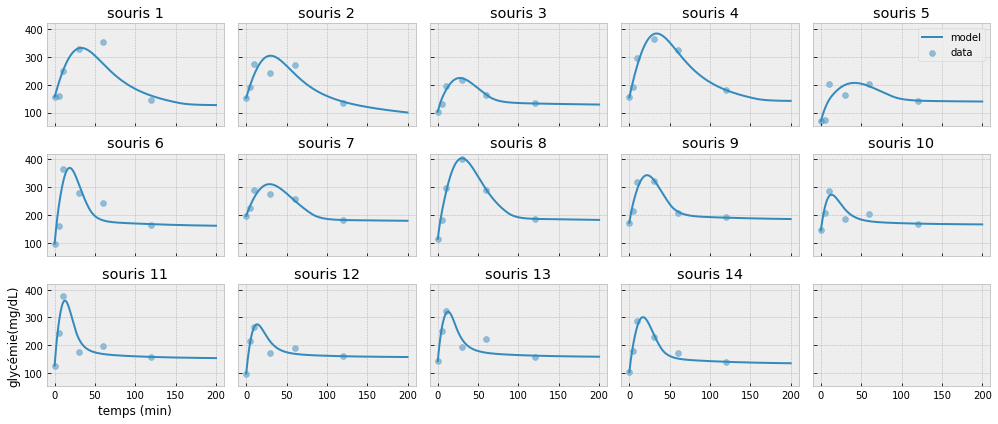

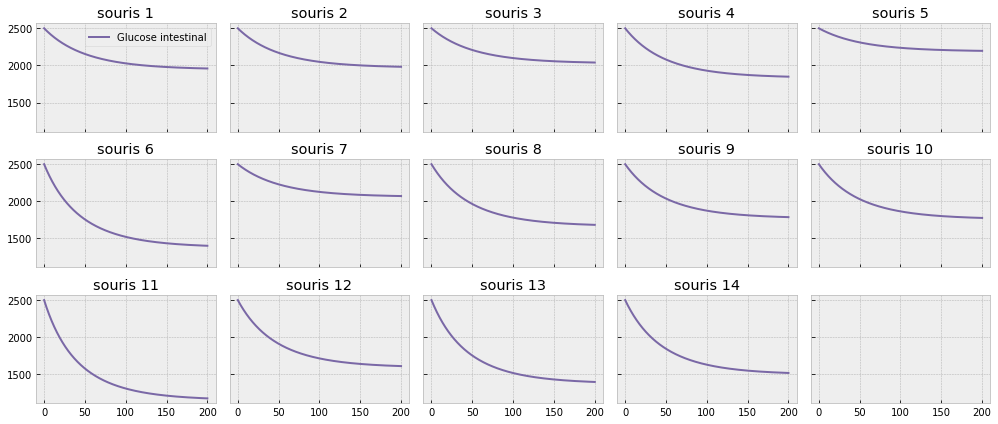

In [ ]:
#-- Création figure
fig1, axs1 = plt.subplots(3, 5, figsize=(14, 6), sharex=True, sharey=True)
fig2, axs2 = plt.subplots(3, 5, figsize=(14, 6), sharex=True, sharey=True)

#-- initialisation list et flag
j, w = 0, 0
list_param_souris_ko = []
valeur_gi_souris_ko = []

for i in tqdm(range(1, 15)):
    #-- sélection subplot
    if i == 6:
        j, w = 1, 0
    if i == 11:
        j, w = 2, 0
    #-- sélection souris
    souris_ko = data_ko[1:, i]
    #-- simulation
    model = ModeleGluIns3(t2, (souris_ko[0], 20, 2500), param)
    y = model.fit(data_ko[1:, :], souris_ko, sd=yerr_ko[1:])
    #-- ajout des paramètres à une liste
    list_param_souris_ko.append(model.get_param())
    #-- ajout de la valeur de Gi dans la liste
    valeur_gi_souris_ko.append([y[:,2][0]-y[:,2][-1]])
    #-- figure 1
    axs1[j][w].plot(t2, y[:, 0], label='model')
    axs1[j][w].scatter(data_ko[1:, 0], souris_ko, alpha=0.5, label='data')
    axs1[j][w].set_title(f'souris {i}')
    #-- figure 2
    axs2[j][w].plot(t2, y[:, 2], label='Glucose intestinal', c='C2')
    axs2[j][w].set_title(f'souris {i}')
    w += 1
    
#-- légende
axs1[0][4].legend()
axs1[2][0].set_ylabel('glycémie(mg/dL)')
axs1[2][0].set_xlabel('temps (min)')
axs2[0][0].legend()

#-- affichage
fig1.tight_layout()
fig2.tight_layout()
fig1.show()
fig2.show()

In [ ]:
#-- nom des colones et des index pour le dataframe
index_ko = []
for i in range(1, 15):
    index_ko.append(f'Souris {i}')
columns = ['a_ko', 'b_ko', 'c_ko', 'd_ko', 'gs_ko', 'k_ko', 'U0_ko']

#-- Création dataframe 
df_souris_ko = pd.DataFrame(data=list_param_souris_ko, index=index_ko, columns=columns)

#-- affichage 
print(df_souris_ko)

#-- exportation 
df_souris_ko.to_excel('param_modele_avance_souris_ko.xlsx')
df_souris_ko.to_csv('param_modele_avance_souris_ko.csv', header=True, index=True)

           a_ko      b_ko  c_ko     d_ko       gs_ko   k_ko     U0_ko
Souris 1   0.06  0.000172  0.03  0.00005  134.516476  0.018  0.004513
Souris 2   0.06  0.000231  0.03  0.00005   94.791648  0.018  0.004298
Souris 3   0.06  0.000523  0.03  0.00005  157.397656  0.018  0.003769
Souris 4   0.06  0.000137  0.03  0.00005  150.234671  0.018  0.005586
Souris 5   0.06  0.000278  0.03  0.00005  158.875617  0.018  0.002395
Souris 6   0.06  0.000568  0.03  0.00005  223.112650  0.018  0.010707
Souris 7   0.06  0.000178  0.03  0.00005  205.021985  0.018  0.003482
Souris 8   0.06  0.000181  0.03  0.00005  208.539628  0.018  0.007318
Souris 9   0.06  0.000326  0.03  0.00005  239.789508  0.018  0.006210
Souris 10  0.06  0.001071  0.03  0.00005  299.999908  0.018  0.006322
Souris 11  0.06  0.001071  0.03  0.00005  257.444118  0.018  0.013947
Souris 12  0.06  0.001339  0.03  0.00005  299.999909  0.018  0.008129
Souris 13  0.06  0.001099  0.03  0.00005  277.017506  0.018  0.010759
Souris 14  0.06  0.0

### Analyse statistique

In [ ]:
print(df_souris_control.describe())
print(df_souris_ko.describe())

             a_ctrl     b_ctrl        c_ctrl        d_ctrl     gs_ctrl  \
count  1.500000e+01  15.000000  1.500000e+01  1.500000e+01   15.000000   
mean   6.000000e-02   0.000788  3.000000e-02  5.000000e-05  185.906902   
std    2.872975e-17   0.000785  1.436488e-17  1.402820e-20   85.949168   
min    6.000000e-02   0.000053  3.000000e-02  5.000000e-05   73.843101   
25%    6.000000e-02   0.000204  3.000000e-02  5.000000e-05  106.554717   
50%    6.000000e-02   0.000305  3.000000e-02  5.000000e-05  172.378060   
75%    6.000000e-02   0.001427  3.000000e-02  5.000000e-05  270.356453   
max    6.000000e-02   0.002268  3.000000e-02  5.000000e-05  299.999993   

       k_ctrl    U0_ctrl  
count  15.000  15.000000  
mean    0.018   0.005583  
std     0.000   0.003204  
min     0.018   0.000904  
25%     0.018   0.003376  
50%     0.018   0.005032  
75%     0.018   0.007601  
max     0.018   0.011403  
               a_ko       b_ko          c_ko          d_ko       gs_ko  \
count  1.400000e

In [ ]:
np.mean(valeur_gi_souris_ko)

753.5574396053734

In [ ]:
valeur_gi_souris_control

[[302.834937652166],
 [185.4508187120905],
 [1033.28124371253],
 [530.0043195965989],
 [724.050322403961],
 [606.1181227007862],
 [354.0898247921732],
 [477.9612642565439],
 [571.8380696707388],
 [812.895186661013],
 [119.16721036330046],
 [595.1958667546307],
 [1150.0366575027265],
 [870.8380274729668],
 [1050.8622458317645]]

In [ ]:
np.mean(valeur_gi_souris_control)

625.641607872266

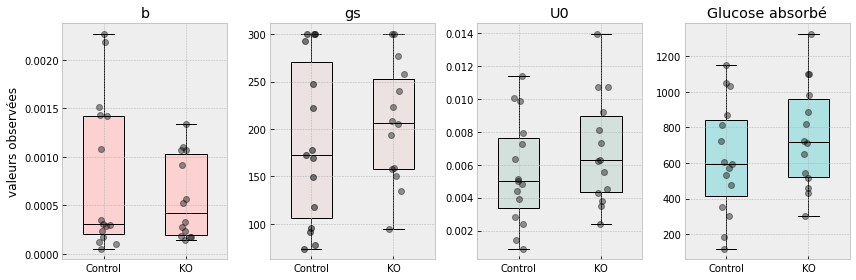

In [ ]:
#-- Création de la figure
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))

#-- Boxplot
ax1.boxplot((df_souris_control.b_ctrl, df_souris_ko.b_ko), 
            labels=["Control", "KO"], 
            patch_artist=True, 
            widths=0.5,
            boxprops={"facecolor": "#FCD1D1"},
            medianprops={"color": "k"},
            showfliers=False,
            zorder=1)
ax2.boxplot((df_souris_control.gs_ctrl, df_souris_ko.gs_ko), 
            labels=["Control", "KO"], 
            patch_artist=True, 
            widths=0.5,
            boxprops={"facecolor": "#ECE2E1"},
            medianprops={"color": "k"},
            showfliers=False,
            zorder=1)
ax3.boxplot((df_souris_control.U0_ctrl, df_souris_ko.U0_ko), 
            labels=["Control", "KO"], 
            patch_artist=True, 
            widths=0.5,
            boxprops={"facecolor": "#D3E0DC"},
            medianprops={"color": "k"},
            showfliers=False,
            zorder=1)
ax4.boxplot((np.ravel(valeur_gi_souris_control), np.ravel(valeur_gi_souris_ko)), 
            labels=["Control", "KO"], 
            patch_artist=True, 
            widths=0.5,
            boxprops={"facecolor": "#AEE1E1"},
            medianprops={"color": "k"},
            showfliers=False,
            zorder=1)
  
#-- Scatter
def rand_dot(position, data):
    return np.random.normal(position, 0.04, size=len(data))

ax1.scatter(rand_dot(1, df_souris_control.b_ctrl), df_souris_control.b_ctrl, c='k', alpha=0.4, zorder=2, lw=1)
ax1.scatter(rand_dot(2, df_souris_ko.b_ko), df_souris_ko.b_ko, c='k', alpha=0.4, zorder=2, lw=1)
ax2.scatter(rand_dot(1, df_souris_control.gs_ctrl), df_souris_control.gs_ctrl, c='k', alpha=0.5, zorder=2, lw=1)
ax2.scatter(rand_dot(2, df_souris_ko.gs_ko), df_souris_ko.gs_ko, c='k', alpha=0.4, zorder=2, lw=1)
ax3.scatter(rand_dot(1, df_souris_control.U0_ctrl), df_souris_control.U0_ctrl, c='k', alpha=0.4, zorder=2, lw=1)
ax3.scatter(rand_dot(2, df_souris_ko.U0_ko), df_souris_ko.U0_ko, c='k', alpha=0.4, zorder=2, lw=1)
ax4.scatter(rand_dot(1, valeur_gi_souris_control), valeur_gi_souris_control, c='k', alpha=0.4, zorder=2, lw=1)
ax4.scatter(rand_dot(2, valeur_gi_souris_ko), valeur_gi_souris_ko, c='k', alpha=0.4, zorder=2, lw=1)

#-- légendes
ax1.set_title("b")
ax1.set_ylabel("valeurs observées")
ax2.set_title("gs")
ax3.set_title("U0")
ax4.set_title("Glucose absorbé")


#-- Affichage
fig.tight_layout()
fig.show()